<br>

### 필요한 라이브러리 <br>

회귀 모델을 구현하는 데에 사용하는 xgboost와 lightgbm 라이브러리와, 결측 데이터를 확인하는 missingno 라이브러리가 필요합니다. 

```
$ conda install -c conda-forge xgboost
$ conda install -c conda-forge lightgbm
$ conda install -c conda-forge missingno
```

<br>

In [1]:
"""
matplotlib 시각화를 위한 코드
"""

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<br>

# Baseline 커널에 있는 코드

<br>

In [27]:
# 전체 코드를 실행시키는 데에 필요한 모든 라이브러리

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
"""
데이터 경로
캐글 서버 : ../input
로컬 서버 : ~/(데이터 들어있는 폴더 경로)
"""

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/ssac29/aiffel/kaggle_kakr_housing/data/train.csv
/home/ssac29/aiffel/kaggle_kakr_housing/data/test.csv


<br>

## 1. 데이터 읽어오기, 살펴보기 <br>

pandas의 read_csv 함수를 사용해 데이터를 읽어와 각 변수들이 나타내는 의미를 살펴보기.<br><br>

1. ID : 집을 구분하는 번호 <br>
2. date : 집을 구매한 날짜 <br>
3. price : 타겟 변수인 집의 가격 <br>
4. bedrooms : 침실의 수 <br>
5. bathrooms : 침실당 화장실 개수 <br>
6. sqft_living : 주거 공간의 평방 피트 <br>
7. sqft_lot : 부지의 평방 피트 <br>
8. floors : 집의 층 수 <br>
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰) <br>
10. view : 집이 얼마나 좋아 보이는지의 정도 <br>
11. condition : 집의 전반적인 상태 <br>
12. grade : King County grading 시스템 기준으로 매긴 집의 등급 <br>
13. sqft_above : 지하실을 제외한 평방 피트 <br>
14. sqft_basement : 지하실의 평방 피트 <br>
15. yr_built : 집을 지은 년도 <br>
16. yr_renovated : 집을 재건축한 년도 <br>
17. zipcode : 우편번호 <br>
18. lat : 위도 <br>
19. long : 경도 <br>
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) <br>
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) <br>

<br>

<br>

### 판다스 데이터 프레임으로 불러와 형태 확인

<br>

In [4]:
"""
pandas 로 데이터 불러와 데이터 형태 확인
( 예측해야할 집의 가격 데이터 price 가 없기 때문에 컬럼이 하나 적게 나옴 )
"""

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


<br>

### 학습 데이터에서 레이블 제거

'price' 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼은 지워줍니다. <br><br>

참고. <br>
[파이썬 del](https://www.w3schools.com/python/ref_keyword_del.asp) <br>
[판다스 drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

<br>

In [5]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


<br>

### 데이터 탐색을 위해 학습 데이터와 테스트 데이터 합치기 <br><br>

모델을 학습시키기 전에, 전체 데이터에 대한 탐색을 위해 학습데이터와 테스트데이터를 pd.concat 으로 합쳐봅니다. <br><br>

모델 학습 진행시에는 다시 분리하여 사용해야 하므로, <br>
데이터를 합치기 전 train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용합니다.

<br>

In [6]:
"""
모델 학습 전에 '전체 데이터 탐색'을 위해 train data set 과 test data set 병합
( 나중에 학습을 위해 다시 나누기 위해 데이터를 합치기 전 train_len에 training data의 개수를 저장 )
"""

train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<br>

## 2. 데이터 전처리 : 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

<br>

<br>

### 결측치 확인 <br><br>

#### 시각화 라이브러리로 결측치 확인 <br>

먼저 데이터에 결측치(NaN/Null)가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<br>

<AxesSubplot:>

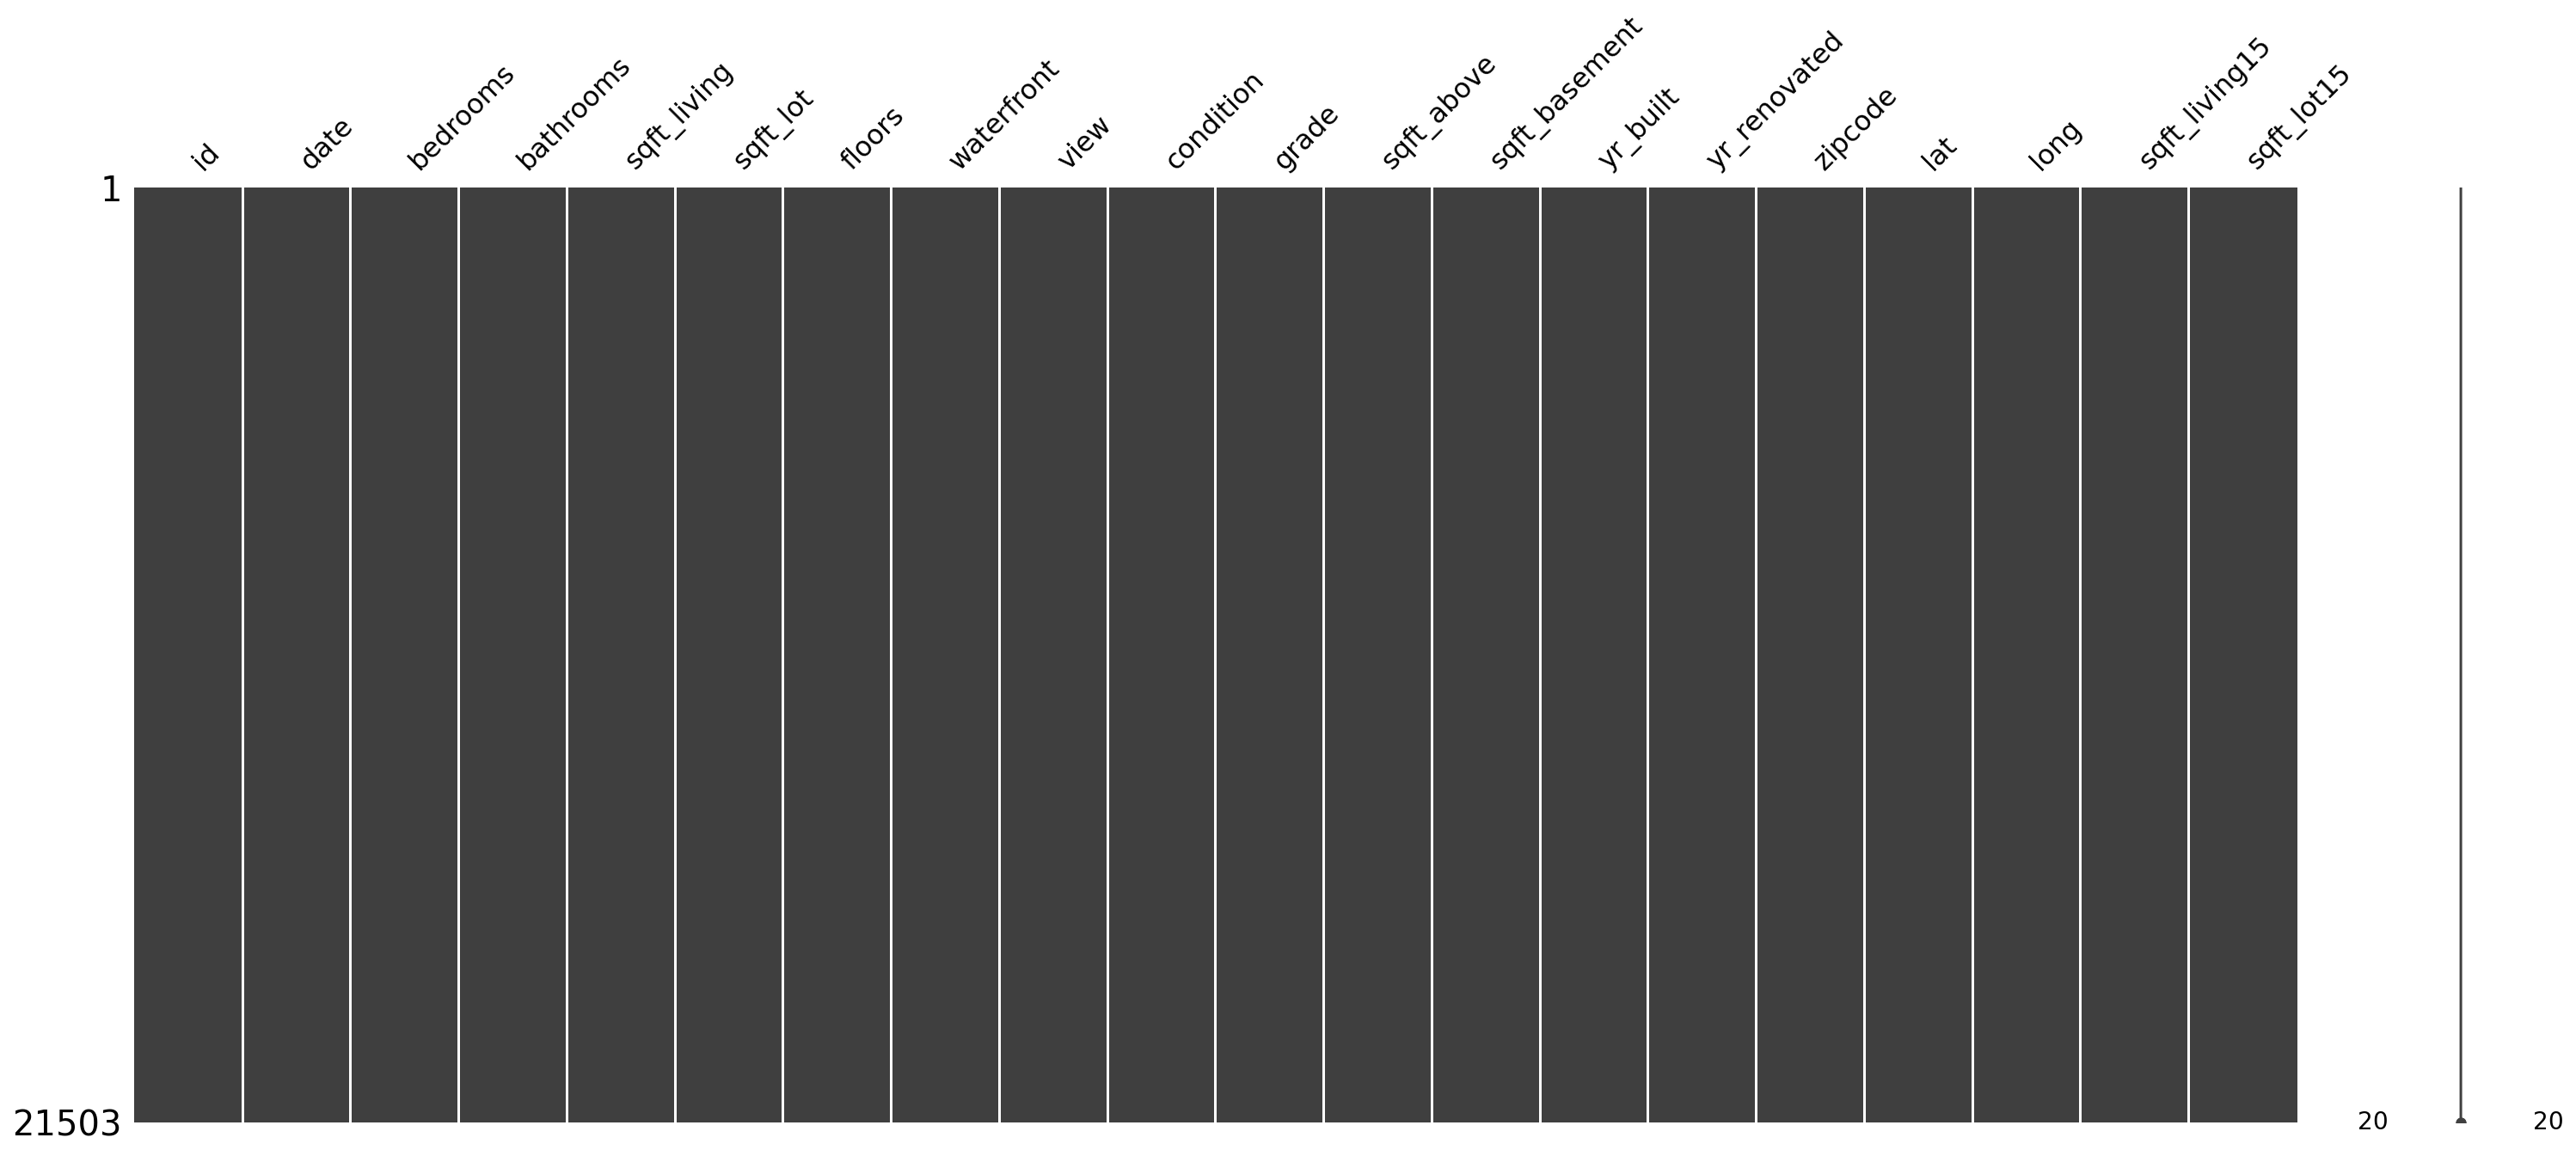

In [8]:
"""
msno.matrix() 사용하여 데이터 결측상태 시각화
( DataFrame을 매트릭스 모양 그대로 시각화 )
출력결과 : data라는 DataFrame을 매트릭스 모양 그대로 시각화한 것
결측결과 : 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옵니다
         결측치가 없다면 매트릭스 전체가 까맣게 나옵니다
"""

msno.matrix(data)

<br>

#### feature 칼럼별 NaN 개수로 결측치 확인 <br><br>

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다. <br><br>

참고. <br>
[데이터프레임 고급 인덱싱](https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1)

<br>

In [9]:
"""
pandas 데이터프레인 인덱싱과 isnull()로 Nan 결측치 갯수 확인
"""

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


<br>

### 학습에 필요 없는 데이터 정리, 수정 <br><br>

- id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거 <br>
( 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장 ) <br>
- date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 수정 <br>
( apply 함수로 mapping 을 통해 수정 )

<br>

In [10]:
"""
학습에 필요 없는 컬럼 제거
( 나중을 위해 따로 변수에 저장 )
"""

# 한번 지우고 다시 실행하면 'id'가 data 데이터프레임에 없는 상태이므로 에러 뜸 주의.

sub_id = data['id'][train_len:]     # 나중을 위해 변수에 따로 저장
del data['id']                      # 학습에 필요 없는 컬럼 제거


data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)    # apply 함수로 date 정보 수정
# str(x[:6]) 처리 : 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위함

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<br>

### 각 변수들의 분포 확인 <br><br>

한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다. <br>
변수의 (시각적) 분포확인을 위해 각 변수의 데이터들에 대해 그래프를 그려줍니다. <br><br>

[__seaborn.kdeplot__](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) 사용 <br>
kdeplot 은 discrete data 도 부드러운 곡선으로 표현하여 전체 분포를 확인할 수 있도록 도와줍니다.

<br>

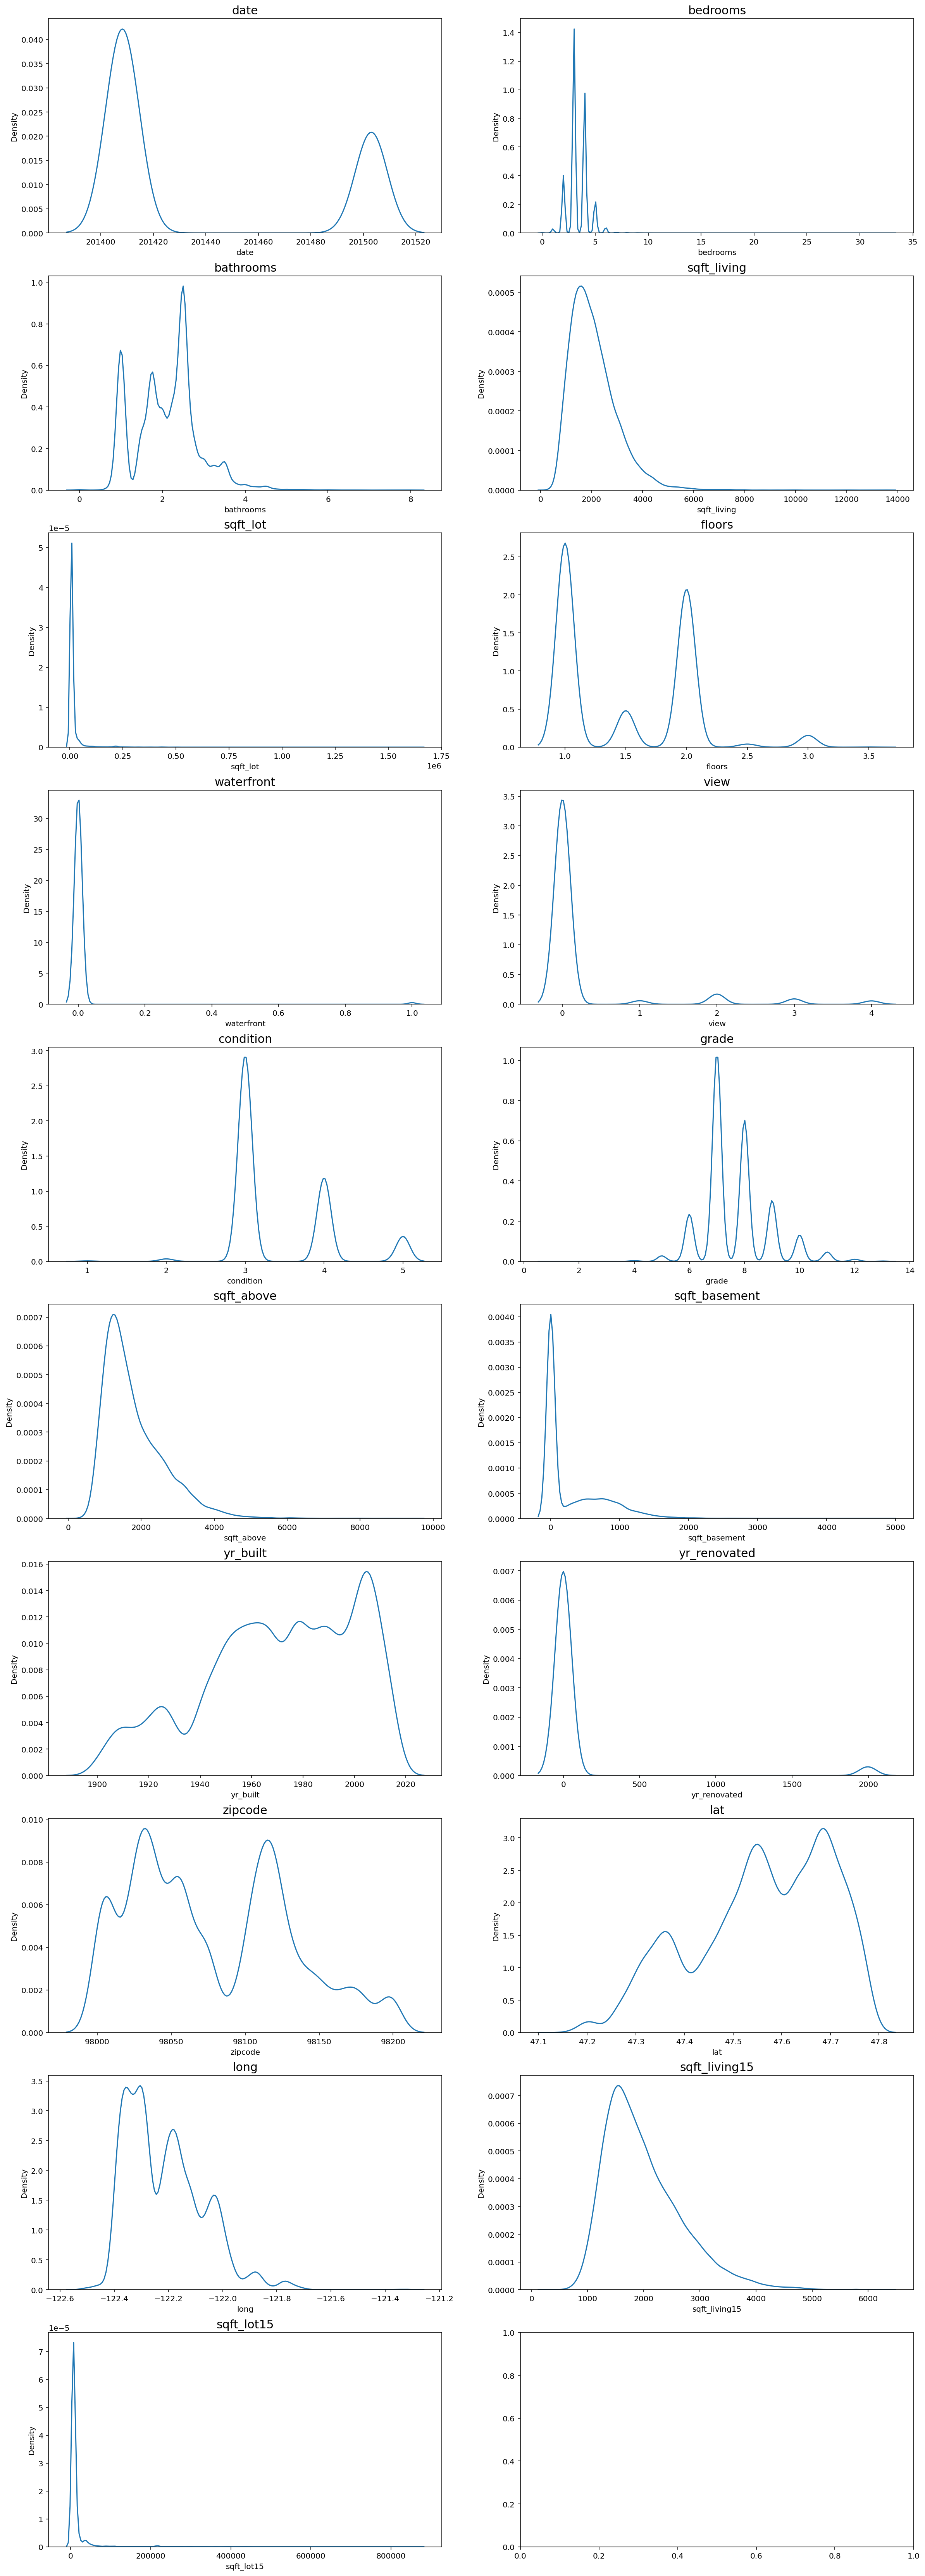

In [11]:
"""
seaborn 라이브러리로 (id 컬럼 제외) 19개 컬럼에 대해 모든 그래프 생성
"""

fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

<br>

### 치우친(skew) 분포 데이터 변환 <br><br>


price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다. <br><br><br>



#### 로그변환 (log-scaling) <br>

한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다. <br>
log-scaling을 통해 데이터 분포를 __정규분포에 가깝게__ 만들어 보겠습니다. <br><br>

__numpy.log1p()__ 사용 <br>
입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수

<br>

<br>

### 로그변환 <br><br>


분포 그래프의 변환에서 log(1 + x) 로그함수를 사용하는 이유는 로그함수 그래프의 특성에 기인합니다. <br>
그 특성에 의해 한 쪽으로 몰려있는 분포에 로그변환을 취하면 넓게 퍼지게 됩니다. <br>

``` python
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()
```

<br>

왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까요? <br>
이는 로그 함수의 형태를 보면 알 수 있습니다. <br><br>

로그 함수의 특징은 다음과 같습니다. <br>

- 0 < x < 1 범위에서는 기울기가 매우 가파릅니다. 즉, x 의 구간은 (0, 1) 로 매우 짧은 반면, y 의 구간은 (−∞, 0) 으로 매우 큽니다. <br>
- 따라서 0에 가깝게 모여있는 값들이 x 로 입력되면, 그 함수값인 y 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다. <br>
- 반면, x 값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 x 값들에 대해서는 y 값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x 를 비교적 작은 y 값의 구간 내에 모이게 하는 특징을 가집니다.

<br>

In [12]:
"""
치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환
numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수
"""

# skew 데이터만 따로 모아주기
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# skew 데이터에 대해 log(1 + x) 변환
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

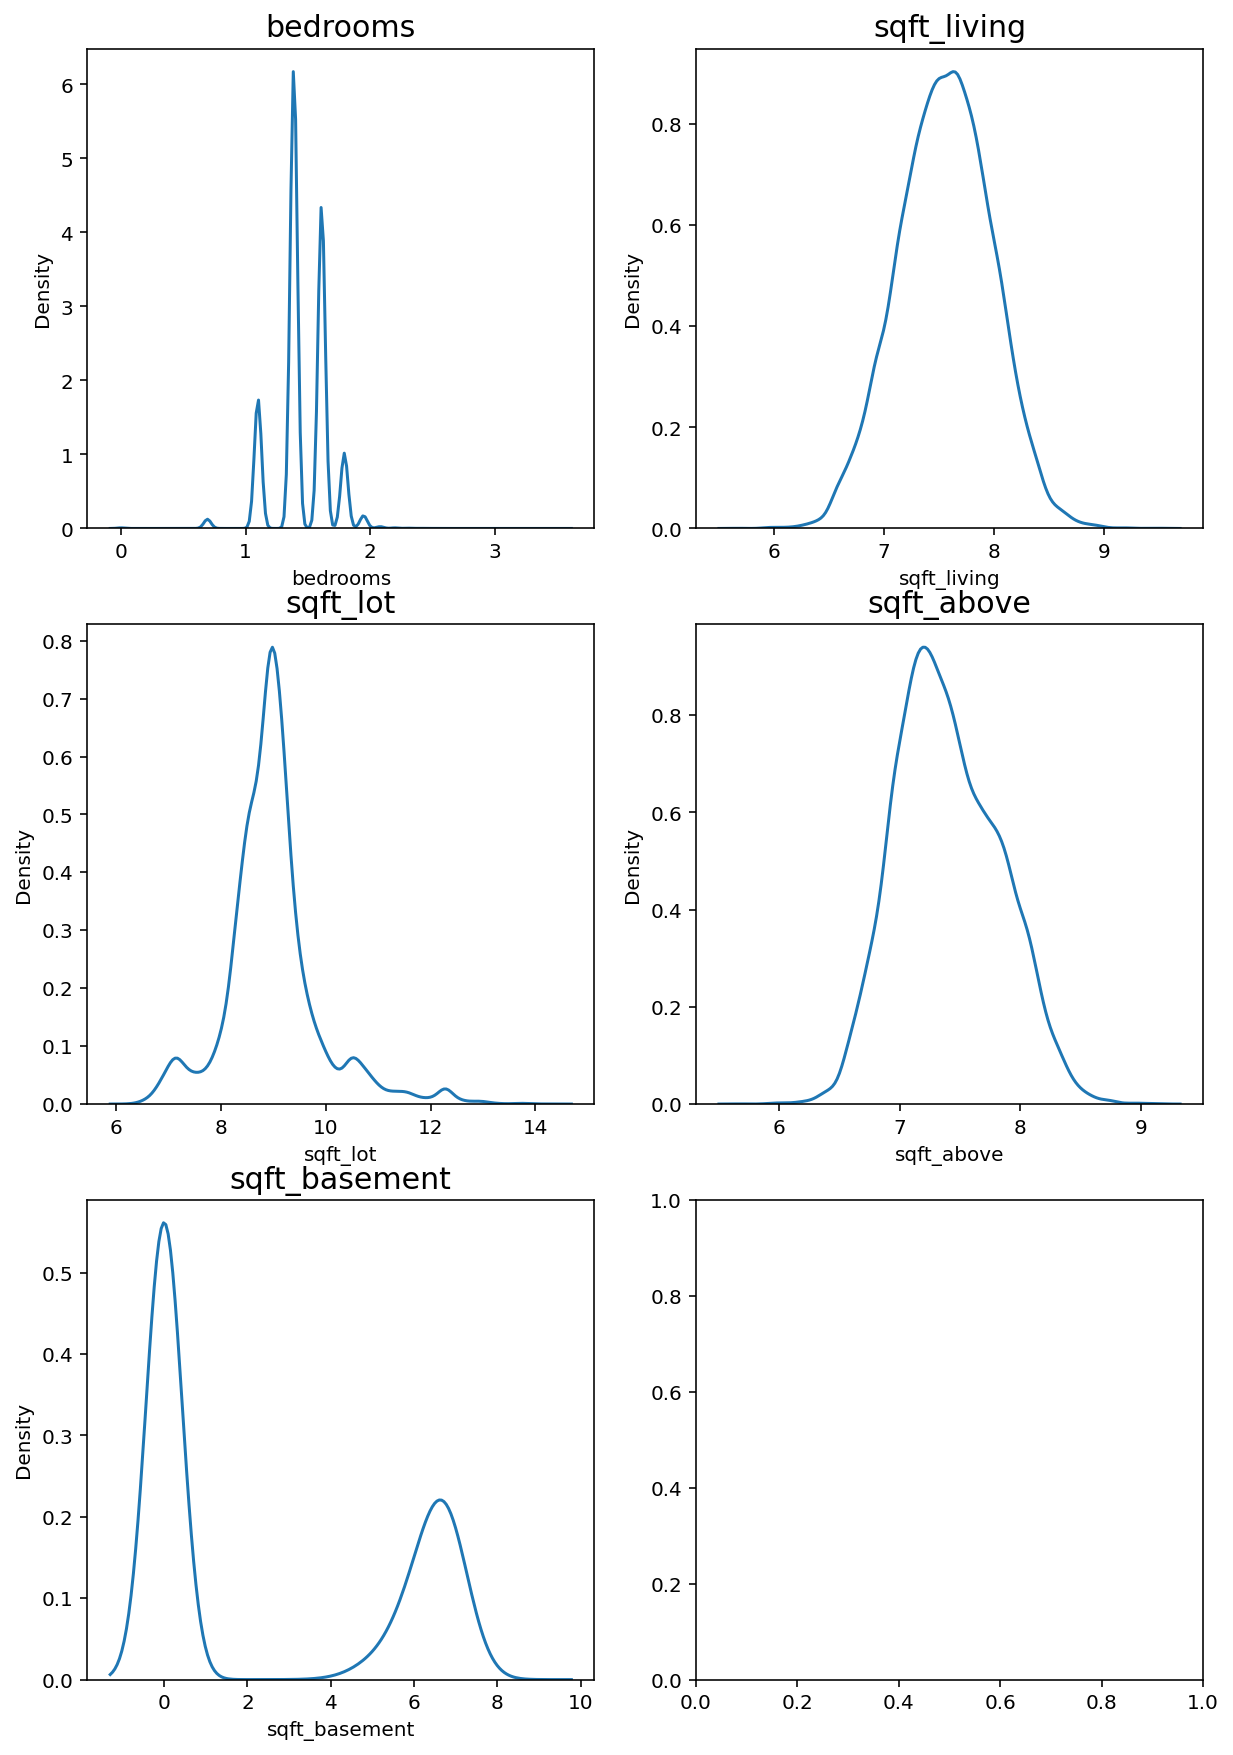

In [13]:
"""
seaborn 라이브러리로 로그변환(log-scaling)된 skew data 들에 대해 분포 그래프 확인
"""

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



<br>

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

<br>

<br>

### 데이터 탐색 후, 병합된 데이터를 Train / Test dataset 으로 재분할 <br><br>

위에서 저장해두었던 train_len을 인덱스로 활용해서 <br>
- :train_len까지는 학습 데이터, 즉 x에 저장하고, <br>
- train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장

<br>

In [14]:
"""
데이터 탐색 및 처리 완료 후,
위에서 병합한 데이터를 다시 train set 과 test set 으로 분할
"""

sub = data.iloc[train_len:, :]      # 위에서 저장해 놓은 변수 train_len 인덱스로 활용
x = data.iloc[:train_len, :]        # 위에서 저장해 놓은 변수 train_len 인덱스로 활용

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


<br>

## 3. 모델링 <br><br>

### Average Blending <br>

여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다. <br><br>

블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다. <br>
블렌딩은 앙상블 기법이라고 하기도 하는데요, 자세한 내용을 다음 포스팅에서 살짝 읽어보겠습니다.

<br>

<br>

### 앙상블 모델 생성 <br><br>

#### Neumerical Ensemble : Average Blending <br>

회귀 문제를 위해 예측 결과를 평균 내어 활용하는 Average Blending 앙상블 기법 사용 <br><br>

네 가지 부스팅 계열 모델 사용 <br>
- __XGBRegressor__ <br>
- __LGBMRegressor__ <br>
- __GradientBoostingRegressor__ <br>
- __RandomForestRegressor__

<br>

In [16]:
'''
부스팅 계열 모델인 gboost, xgboost, lightgbm, randomforest 
네 가지 모델의 결과를 산술평균하여 Average Blending 모델 생성
'''

random_state=2020        # 고정값 2020 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

<br>

### 모델 평가 척도 생성 : RMSE

평가 척도로 RMSE 값을 사용합니다. <br>
이를 위해 scikit-learn의 mean_suared_error 함수를 사용합니다. <br><br>

```
주의.
y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에
원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 합니다.
```
<br>

In [17]:
# 데이터 훈련셋과 검증셋 나누기 위해 train_test_split 함수 불러오기
# RMSE 점수 계산에 필요한 mean_squared_error 불러오기

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
# RMSE 계산을 위한 함수 작성

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

<br>

### 모델별 학습 및 평가

위에서 생성한 models 리스트를 돌며 모델별로 학습 후 평가지표인 RMSE 값 계산

<br>

In [ ]:
"""
모델을 생성하여 저장한 models 리스트를 돌며
각 모델별로 학습하고 평가하는 함수 작성
"""

"""
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

<br>

## 하이퍼파라미터 튜닝 <br><br>

1. 데이터셋과 모델을 준비하였고, <br>
2. 모델학습과 평가(RMSE계산)를 위한 함수도 준비되었습니다. <br>
3. 학습성능을 높이기 위한 하이퍼파라미터 튜닝(조정)만 남았습니다.

<br>

<br>

### Grid Search 로 하이퍼파라미터를 서칭하는 모델 생성 <br><br>

Scikit-Learn 에서 하이퍼파라미터 서칭 함수에 기존의 모델과 인자들을 넣어 새로운 학습모델을 생성하면, 서칭된 여러 하이퍼파라미터 조합들에 대한 학습과 평가 결과를 한번에 얻을 수 있습니다.

<br>

<br>

#### Scikit-Learn 의 GridSearchCV

다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 GridSearchCV를 활용 <br><br>

__GridSearchCV 인자__ <br>
```
# param_grid    : 탐색할 파라미터의 종류    ( 딕셔너리로 입력 )
# scoring       : 모델의 성능을 평가할 지표
# cv            : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
# verbose       : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양
                 ( 숫자가 클수록 더 많은 메세지를 출력 )
# n_jobs        : 그리드 탐색을 진행하면서 사용할 CPU의 개수
```
<br>

In [28]:
"""
Scikit-Learn 에서 그리드 서치 모델을 생성하고 학습하여
최적의 하이퍼파라미터 결과를 출력하는 함수 작성
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                                        scoring='neg_mean_squared_error', \
                                        cv=5, \
                                        verbose=verbose, \
                                        n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

<br>

### 하이퍼파라미터 서칭

위에서 작성한 하이퍼파라미터 서칭 결과를 출력하는 함수 my_GridSearch() 로 그리드 탐색

<br>

In [30]:
"""
그리드 서칭 모델 생성 후, 
그리드 탐색
"""

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

for i in models:
    print(my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.6s finished
   max_depth  n_estimators         score          RMSLE
3         10           100 -1.636424e+10  127922.786707
2         10            50 -1.723326e+10  131275.530734
1          1           100 -3.851269e+10  196246.498903
0          1            50 -4.787553e+10  218804.781607
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.7s finished
   max_depth  n_estimators         score          RMSLE
3         10           100 -1.636424e+10  127922.786707
2         10            50 -1.723326e+10  131275.530734
1          1           100 -3.851269e+10  196246.498903
0          1            50 -4.787553e+10  218804.781607
Fitting 5 folds for each of 4 

<br>

### 최적의 하이퍼파라미터로 모델 결과 생성

가장 좋은 조합은 max_depth = 10, n_estimators = 100 입니다. <br>
해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출합니다.

<br>

In [31]:
"""
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
"""

random_state=2020        # 고정값 2020 세팅

gboost = GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=random_state)
xgboost = XGBRegressor(max_depth=10, n_estimators=100, random_state=random_state)
lightgbm = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

<br>

### Average Blending

models 딕셔너리 안에 있는 모델들을 모두 x와 y로 학습시킨 뒤, <br>
predictions에 예측 결과값을 모아서 __평균한 값__을 반환하는 함수를 만들어 사용합니다.

<br>

In [39]:
# 학습된 모델로 average blending 예측값을 생성하는 함수 작성

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [40]:
# 예측값 생성

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

AttributeError: 'GradientBoostingRegressor' object has no attribute 'estimators_'

<br>

### 최적의 하이퍼파라미터 서칭 후 제출하는 함수 작성

잘 예측된 결과를 확인 후, 이 결과를 캐글에 제출하기 위해 <br>
제출용 포맷에 맞게 데이터프레임을 생성한 뒤 csv 파일로 저장

<br>

In [36]:
"""
`save_submission(model, train, y, test, model_name, rmsle)` 함수
1. 모델을 `train`, `y`로 학습
2. `test`에 대해 예측
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [38]:
# 위 save_submission() 함수 한줄로 
# 최적의 하이퍼파라미터 모델을 합습한 후 예측 결과 저장

save_submission(models, x, y, sub, 'lgbm', rmsle='0.0168')

AttributeError: 'list' object has no attribute 'fit'

<br>

### 캐글에 csv 파일 업로드 하여 제출

score : 120031.23722 <br><br>

마지막 Average Blending 과정에서 오류가 발생하여 Base_line 모델 score 로 120031.23 점 달성하였습니다.


<br>